In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

In [2]:
df0 = pd.read_csv("data/insurance.csv")
df0.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


***

## A. Problem Statement and Exploratory Data Analysis 

### A.1. Definition of Problem Statement :

We will analyze the insurance company medical records data and answer certain questions such as :

 - Which variables are significant in predicting the reason for hospitalization for different regions.
 - How well some variables like viral load, smoking, Severity Level describe the hospitalization charges.
 - What are some action items/recommendations/business insights that our analysis can yeild.
 
We will perform exploratory data analysis and test for certain hypotheses (for eg. hospitalization costs depend on smoker/non-smoker status) using tests like 2 sample T, One way ANOVA, chi square, etc.
 
 ***

### A.2. Basic observations on shape of data, data types of all the attributes, missing value detection, statistical summary.

In [3]:
df0.shape

(1338, 8)

So we see that the dataset has 1338 observations and 8 features (of which one feature is useless 'Unnamed: 0' and we will drop it later).

#### Column Profiling
 - <b>Age</b>: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
 - <b>Sex</b>: This is the policy holder's gender, either male or female
 - <b>Viral Load</b>: Viral load refers to the amount of virus in an infected person's blood
 - <b>Severity Level</b>: This is an integer indicating how severe the patient is
 - <b>Smoker</b>: This is yes or no depending on whether the insured regularly smokes tobacco.
 - <b>Region</b>: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
 - <b>Hospitalization charges</b>: Individual medical costs billed to health insurance

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1338 non-null   int64  
 1   age                      1338 non-null   int64  
 2   sex                      1338 non-null   object 
 3   smoker                   1338 non-null   object 
 4   region                   1338 non-null   object 
 5   viral load               1338 non-null   float64
 6   severity level           1338 non-null   int64  
 7   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 83.8+ KB


#### Statistical Summary

In [5]:
df0.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1338.0,668.500000,386.391641,0.00,334.2500,668.50,1002.7500,1337.00
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.0000,64.00
viral load,1338.0,10.221233,2.032796,5.32,8.7625,10.13,11.5675,17.71
severity level,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.0000,5.00
hospitalization charges,1338.0,33176.058296,30275.029296,2805.00,11851.0000,23455.00,41599.5000,159426.00


In [6]:
df0["severity level"]=df0["severity level"].astype('object')
df0.describe(include=['object']).transpose()

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364
severity level,1338,6,0,574


___
### A.3. Handling missing values, outliers and dropping non useful columns

<b>Missing Values</b>: There are no null/missing  values.

In [7]:
Q1 = df0["hospitalization charges"].quantile(0.25)
Q3 = df0["hospitalization charges"].quantile(0.75)
IQR = Q3-Q1

df1 = df0[~(df0["hospitalization charges"]<Q1-1.5*IQR) & ~(df0["hospitalization charges"]>Q3+1.5*IQR)]
df = df0[df0["hospitalization charges"]<df0["hospitalization charges"].quantile(0.95)]

print((df0.shape[0]-df1.shape[0])*100/df0.shape[0])
print((df0.shape[0]-df.shape[0])*100/df0.shape[0])

10.388639760837071
5.007473841554559


<b>Outlier Treatment</b>: 

So we see that if we use IQR method to drop outliers, we end up losing almost 10% of the data points in our dataset.
If we drop the data points beyond {5 and 95} percentile range, we lose about 5% of the data. So we remove the outliers using the second method. 

<b>Dropping non-useful column</b>:

In [8]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

C:\Users\ANWESHA\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


***
### A.4. Univariate Analysis

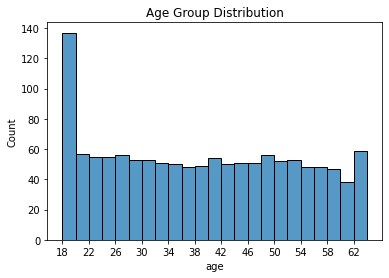

In [10]:
sns.histplot(df["age"], binwidth=2, binrange=(18,64))
plt.xticks(np.arange(18,64,4))
plt.title("Age Group Distribution")

plt.show()

We see that the age group 18-20 has a lot of patients (above 130). The rest of the groups have below 60 patients each.

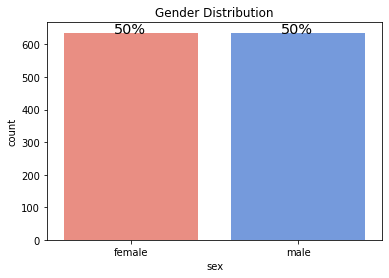

In [11]:
ax = sns.countplot(df["sex"], palette=["salmon","cornflowerblue"])

total = df["sex"].count()

for p in ax.patches:
    txt_x = p.get_x()
    txt_y = p.get_height()
    txt = str(round((txt_y*100)/total)) + "%"
    ax.text(txt_x+0.3,txt_y,txt,fontsize='x-large')

plt.title("Gender Distribution")
plt.show()

So we see that we have almost equal gender distribution.

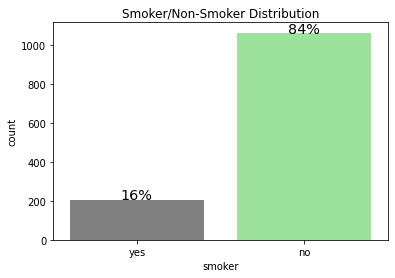

In [12]:
ax = sns.countplot(df["smoker"], palette = ["gray","lightgreen"])

total = df["smoker"].count()

for p in ax.patches:
    txt_x = p.get_x()
    txt_y = p.get_height()
    txt = str(round((txt_y*100)/total)) + "%"
    ax.text(txt_x+0.3,txt_y,txt,fontsize='x-large')

plt.title("Smoker/Non-Smoker Distribution")
plt.show()

Only 16% of the patients are smokers where as 84% are non smokers.

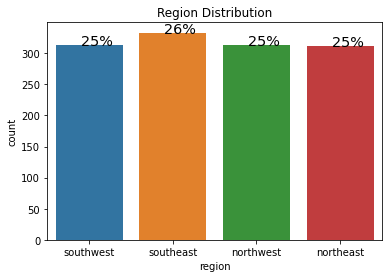

In [13]:
ax = sns.countplot(df["region"])

for p in ax.patches:
    txt_x = p.get_x()
    txt_y = p.get_height()
    txt = str(round((txt_y*100)/total)) + "%"
    ax.text(txt_x+0.3,txt_y,txt,fontsize='x-large')

plt.title("Region Distribution")
plt.show()

Again, regions also have almost similar distribution (25% each).

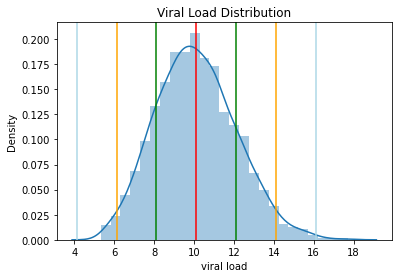

In [14]:
sns.distplot(df["viral load"])

plt.axvline(x=df["viral load"].mean(), color='red')
plt.axvline(x=df["viral load"].mean()-df["viral load"].std(), color='green')
plt.axvline(x=df["viral load"].mean()+df["viral load"].std(), color='green')
plt.axvline(x=df["viral load"].mean()-df["viral load"].std()*2, color='orange')
plt.axvline(x=df["viral load"].mean()+df["viral load"].std()*2, color='orange')
plt.axvline(x=df["viral load"].mean()-df["viral load"].std()*3, color='lightblue')
plt.axvline(x=df["viral load"].mean()+df["viral load"].std()*3, color='lightblue')


plt.title("Viral Load Distribution")
plt.show()

The viral load ditribution looks approximately normal. The mean viral load is around 10. 
- 68% of observations have viral load between 8 and 12.
- 95% of observations have viral load between 6 and 14.
- 99% of observations have viral load between 4 and 16.

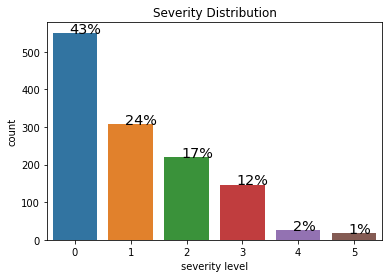

In [15]:
ax = sns.countplot(df["severity level"])

for p in ax.patches:
    txt_x = p.get_x()
    txt_y = p.get_height()
    txt = str(round((txt_y*100)/total)) + "%"
    ax.text(txt_x+0.3,txt_y,txt,fontsize='x-large')

plt.title("Severity Distribution")
plt.show()

Severity level 0 has highest observations (almost 43%), followed by 1 (24%), 2 (17%) and 3 (12%). Very few have severiy 4 and above (less than 2%).

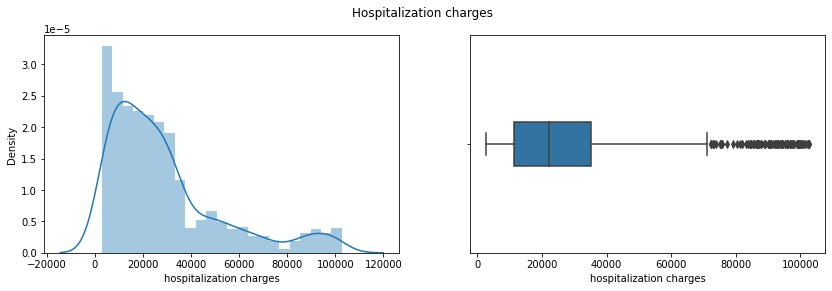

In [16]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.distplot(df["hospitalization charges"],ax=ax[0])

sns.boxplot(df["hospitalization charges"], width=0.2, ax=ax[1])

plt.suptitle("Hospitalization charges")
plt.show()

Hospitalization charges follow a skewed bimodal distribution. We see many observations with hospitalization charges between INR 0 to INR 40000. The number of observations with charges from INR 40000 to INR 80000 reduces. It rises again between INR 80000 and INR 111000. 

This might be because of higher hospitalization charges incurred by smokers. So the second rise is probably due to smoker patients, while the first peak is non smokers.
***

### A.5. Bivariate/Multivariate Analysis

At a glance: 

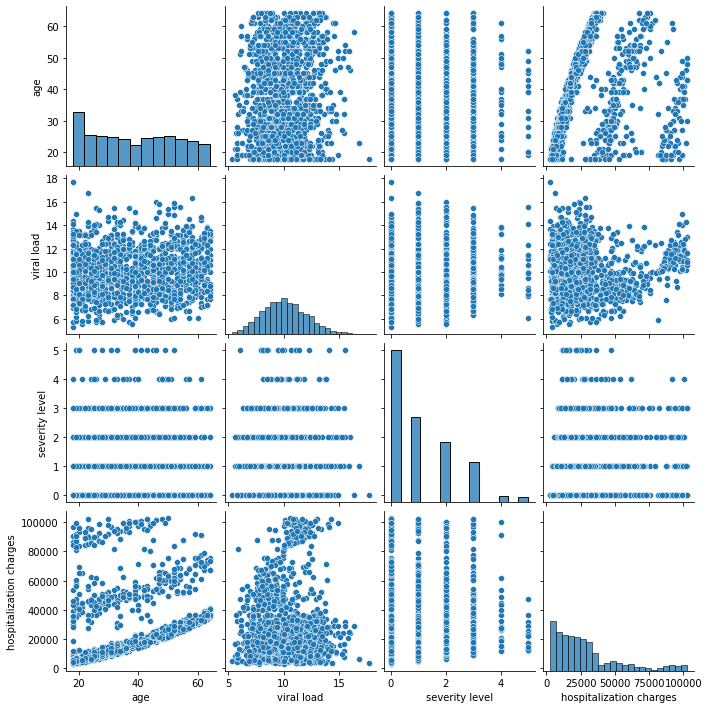

In [17]:
sns.pairplot(df)

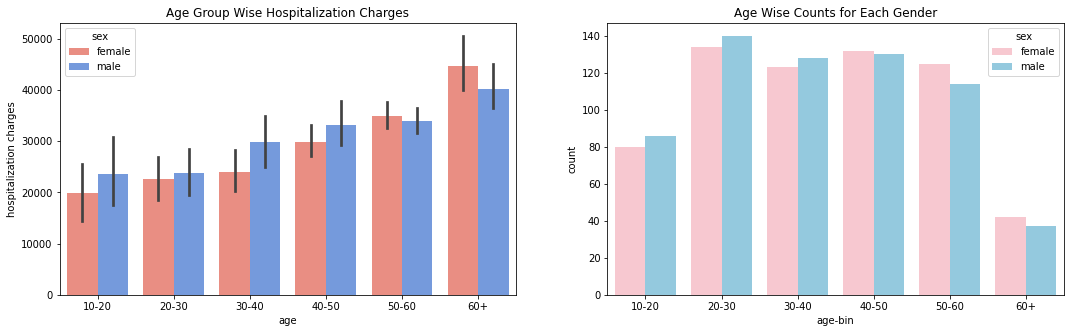

In [18]:
#Create age bins and plot barplot of hospitalization charges
pd.options.mode.chained_assignment = None

df['age-bin'] = pd.cut(df['age'], bins=[10, 20, 30, 40, 50, 60, float('Inf')], labels=['10-20', '20-30','30-40', '40-50','50-60', '60+'])

fig, ax = plt.subplots(1,2,figsize=(18,5))
sns.barplot(x='age-bin',y='hospitalization charges', data=df, hue=df["sex"], palette=["salmon","cornflowerblue"], ax = ax[0])
sns.countplot(df["age-bin"], hue=df["sex"], palette=["pink","skyblue"], ax=ax[1])
ax[0].set_xlabel("age")

ax[0].set_title("Age Group Wise Hospitalization Charges")
ax[1].set_title("Age Wise Counts for Each Gender")
plt.show()

So we see the following :
 - Hospitalization Charges incurred increases with increase in age. 
 - Hospitalization charges increase with age for each gender.
 - In age groups 10-20, 20-30, 30-40, 40-50, males tend to incur more charges than female. However in the 50-60 and 60+ age group, females incur more charges than males.
 - The above point might be because there are more female patients in the 50-60 and 60+ age group. However for the 40-50 age group, despite there being more female patients, male patients still incur more charges overall.

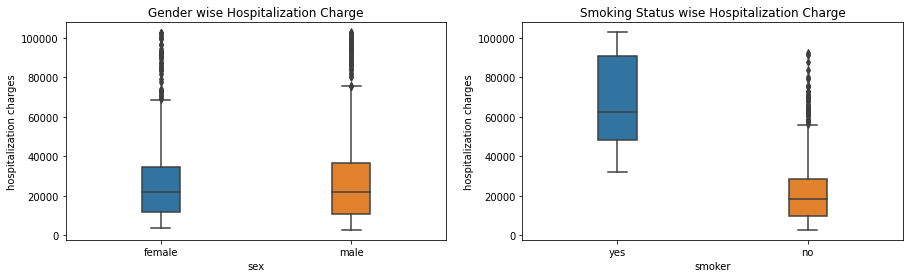

In [19]:
fig,ax = plt.subplots(1,2, figsize=(15,4))

sns.boxplot(x = "sex", y = "hospitalization charges", width = 0.2, data = df, ax=ax[0])
sns.boxplot(x = "smoker", y = "hospitalization charges", width = 0.2, data = df, ax=ax[1])

ax[0].set_title("Gender wise Hospitalization Charge")
ax[1].set_title("Smoking Status wise Hospitalization Charge")

plt.show()

- So it appears that male and female patients have similar hospitalization charges.
- Smokers have a much greater hospitalization charge than non-smokers.

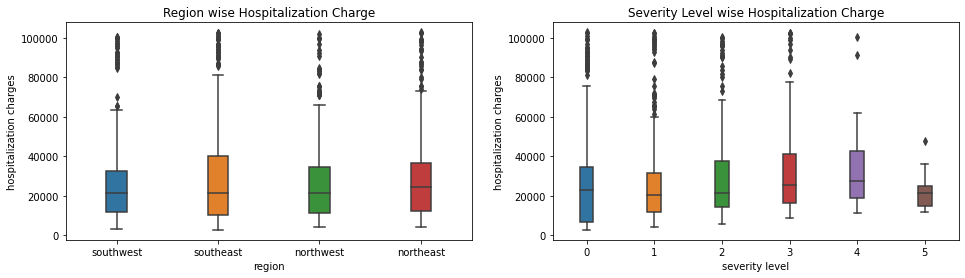

In [20]:
fig,ax = plt.subplots(1,2, figsize=(16,4))

sns.boxplot(x = "region", y = "hospitalization charges", width = 0.2, data = df, ax=ax[0])
sns.boxplot(x = "severity level", y = "hospitalization charges", width = 0.2, data = df, ax=ax[1])

ax[0].set_title("Region wise Hospitalization Charge")
ax[1].set_title("Severity Level wise Hospitalization Charge")

plt.show()

In [21]:
df['severity level'].value_counts(normalize=True)

0    0.433517
1    0.243116
2    0.173879
3    0.115657
4    0.019670
5    0.014162
Name: severity level, dtype: float64

- The different regions seem to have similar trends in median hospitalization charge.
- Severity level 0 strangely, has a little higher median hospitalization charge than 1 and 2. There is a slight increasing trend from levels 1 to 4.
- Severity level 5 again has lower charge (but has only about 1% observations).

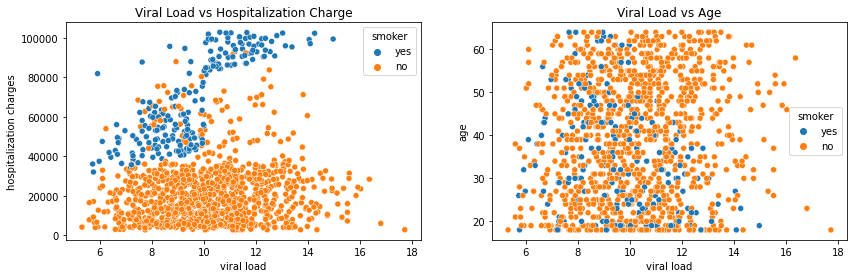

In [22]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.scatterplot(x = df["viral load"], y = df["hospitalization charges"], ax=ax[0], hue=df["smoker"])
sns.scatterplot(x = "viral load", y = "age", hue="smoker",data = df, ax=ax[1])

ax[0].set_title("Viral Load vs Hospitalization Charge")
ax[1].set_title("Viral Load vs Age")

plt.show()

- Visually, there does not seem to be a clear correlation between viral load and hospitalization charges.
- However smokers and non smokers clearly have different clusters (as we saw earlier that smoking status affects hospitalization charge).
- There does not seem to be a clear correlation between viral load and age.

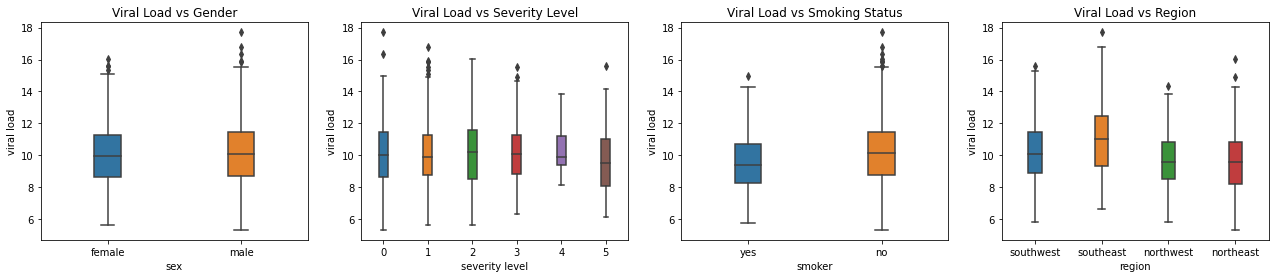

In [23]:
fig, ax = plt.subplots(1,4,figsize=(22,4))

sns.boxplot(x = "sex", y = "viral load", width = 0.2, data = df, ax=ax[0])
sns.boxplot(x = "severity level", y = "viral load", width = 0.2, data = df, ax=ax[1])
sns.boxplot(x = "smoker", y = "viral load", width = 0.2, data = df, ax=ax[2])
sns.boxplot(x = "region", y = "viral load", width = 0.2, data = df, ax=ax[3])

ax[0].set_title("Viral Load vs Gender")
ax[1].set_title("Viral Load vs Severity Level")
ax[2].set_title("Viral Load vs Smoking Status")
ax[3].set_title("Viral Load vs Region")
plt.show()

We observe the following:
 - There does not seem to be much difference between the virl load of male and female patients.
 - There again does not seem to be a clear relation between severity levels and viral load.
 - Viral load of smokers seems to be lower than non-smokers. (Since lower CT values indicate higher load, it appears that the viral load reported is actually the CT value. So smokers have lower CT values and hence higher load).
 - Patients from SouthEast seem to have highest CT value (lowest viral load).

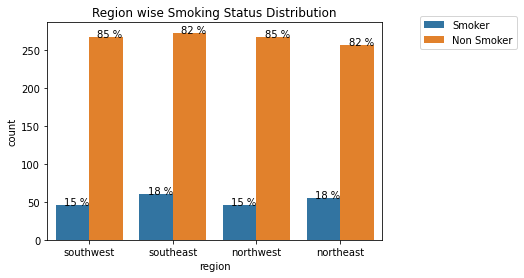

In [24]:
ax = sns.countplot("region", hue="smoker", data = df)

regs = ['southwest', 'southeast', 'northwest', 'northeast']
totals = [df[df["region"]==reg].count()[0] for reg in regs]*2

i=0
for p in ax.patches:
    txt = str(round(p.get_height()*100/totals[i]))+" %"
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x+0.1,txt_y,txt)
    i+=1

ax.legend(bbox_to_anchor=(1.1, 1.05), labels=["Smoker","Non Smoker"])
plt.title("Region wise Smoking Status Distribution")
plt.show()

- Southeast and Northeast have higher smoker percentage (18%) than Southwest and Northwest (15%)

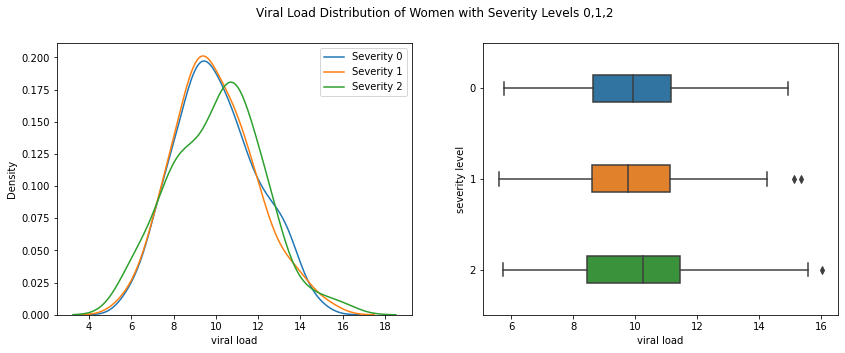

In [25]:
w = df[(df["sex"]=="female") & (df["severity level"].isin([0,1,2]))]

fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.distplot(w[w["severity level"]==0]["viral load"], label="Severity 0", hist=False, ax=ax[0])
sns.distplot(w[w["severity level"]==1]["viral load"], label="Severity 1", hist=False, ax=ax[0])
sns.distplot(w[w["severity level"]==2]["viral load"], label="Severity 2", hist=False, ax=ax[0])
ax[0].legend()

#sns.boxplot(x=w["viral load"],y=w["severity level"], width = 0.3, orient="h", ax=ax[1])
sns.boxplot(x=df[(df["sex"]=="female") & (df["severity level"].isin([0,1,2]))]["viral load"], y=df[df["severity level"].isin([0,1,2])]["severity level"], orient="h", width=0.3, ax=ax[1])

plt.suptitle("Viral Load Distribution of Women with Severity Levels 0,1,2")

plt.show()

In [26]:
df.groupby(["severity level"])["viral load"].mean()[0:3]

severity level
0    10.105662
1    10.105178
2    10.121538
Name: viral load, dtype: float64

- The viral load distributions for severity levels 0 and 1 seem to follow similar distributions.  Severity level 2 is slightly differently distributed.
- However the mean viral load is almost same across all the groups.

***

## B. Hypothesis Testing

### B.1. Prove (or disprove) that the hospitalization of people who do smoking is greater than those who don't? 

In [27]:
df.groupby(['smoker'])['hospitalization charges'].describe()

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1064.0,21085.675752,14984.455500,2805.0,9966.25,18363.5,28407.25,92277.0
yes,207.0,68364.106280,22166.859159,32074.0,48390.50,62175.0,90521.50,102743.0


We check the assumptions (Normality of underlying data of two groups and equality of variances of the two groups).

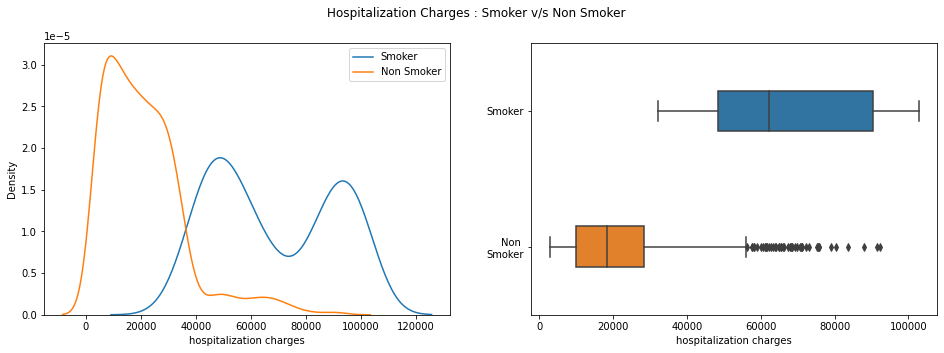

In [28]:
smoker = df[df["smoker"]=="yes"]
nonsmoker = df[df["smoker"]=="no"]

fig, ax = plt.subplots(1,2,figsize=(16,5))

sns.distplot(smoker["hospitalization charges"], hist=False, ax=ax[0], label="Smoker")
sns.distplot(nonsmoker["hospitalization charges"], hist=False, ax=ax[0], label="Non Smoker")
ax[0].legend()

sns.boxplot(x=df["hospitalization charges"], y=df["smoker"], orient="h", width=0.3, ax=ax[1])
ax[1].set_yticklabels(["Smoker","Non \nSmoker"])
ax[1].set_ylabel(" ")

plt.suptitle("Hospitalization Charges : Smoker v/s Non Smoker")
plt.show()

As we see from the above visualizations, neither of the groups follow normal distribution. (Even though mean hospitalization charge for smokers looks a lot higher than non smokers)

We will try to convert them to normal using the box-cox trasnform

In [29]:
import statsmodels.api as sms

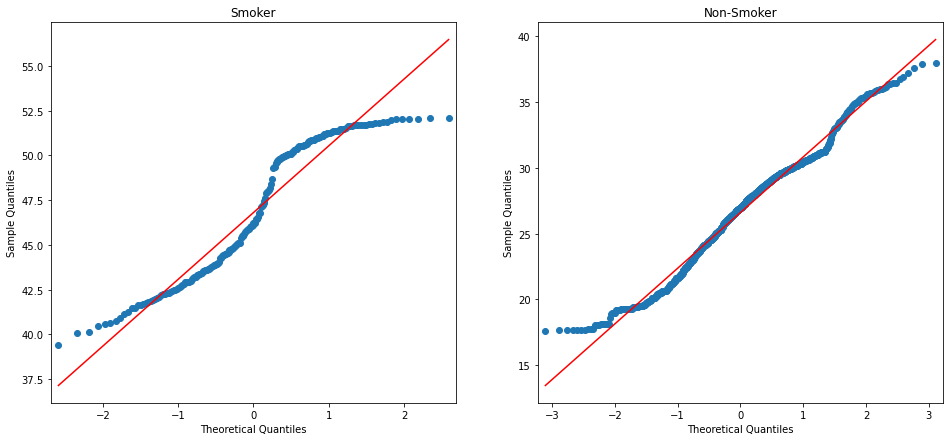

In [30]:
sm_transformed, lambda_sm = stats.boxcox(smoker["hospitalization charges"])
nsm_transformed, lambda_nsm = stats.boxcox(nonsmoker["hospitalization charges"])

fig,ax = plt.subplots(1,2,figsize=(16,7))

sms.qqplot(sm_transformed, line='s', ax=ax[0])
sms.qqplot(nsm_transformed, line='s', ax=ax[1])

ax[0].set_title("Smoker")
ax[1].set_title("Non-Smoker")
plt.show()

So we see that even with BoxCox transformation, we do not get normal data. 

#### Shapiro Wilk Normality Test

In [31]:
sm_transformed = np.random.choice(sm_transformed, size=200)
nsm_transformed = np.random.choice(nsm_transformed, size=200)

In [32]:
stats.shapiro(sm_transformed)

ShapiroResult(statistic=0.9084545969963074, pvalue=8.991457023377336e-10)

In [33]:
stats.shapiro(nsm_transformed)

ShapiroResult(statistic=0.9748859405517578, pvalue=0.001186371548101306)

In [34]:
sm_original = smoker["hospitalization charges"].sample(200)
nsm_original = nonsmoker["hospitalization charges"].sample(200)

In [35]:
stats.shapiro(sm_original)

ShapiroResult(statistic=0.8979042768478394, pvalue=1.8519660804905413e-10)

In [36]:
stats.shapiro(nsm_original)

ShapiroResult(statistic=0.8709369897842407, pvalue=5.0414013241795175e-12)

As we see above, even after performing BoxCox Transform, we do not get normal distributions. 

We performed shapiro test on both transformed and original variables. For all the tests, p-value is a lot less than 0.05. Hence we reject the shapiro null that the data is drawn from normal distributions.

In ohter words, we conclude that the data is not drawn from normal distribution. And since the box cox transform did not help, we simply work with the original data.

#### 

We will next check for equality of variances.

#### Levene's test for equality of variance

In [37]:
stats.levene(sm_original, nsm_original, center="median")

LeveneResult(statistic=45.23358731651763, pvalue=6.096257027105972e-11)

In [38]:
stats.levene(sm_original, nsm_original, center="mean")

LeveneResult(statistic=65.28996430949319, pvalue=7.813577256704505e-15)

We performed Levene's test for the original using both median and mean centering methods. In both cases, the p-value is much less than 0.05. 

So, we reject the Null Hypothesis. This means we have sufficient evidence to say that the variance in hospitalization charges between smoker and non smoker is significantly different.

### T - Test (2 Sample, Right Tailed)

<b>H0 (Null Hypothesis)</b> : Mean hospitalization charge of smoker is equal to non smoker ($\mu_{smoker}$ <= $\mu_{non-smoker}$)

<b>HA (Alternate Hypothesis)</b> : Mean hospitalization charge of smoker is greater than non smoker. ($\mu_{smoker}$ > $\mu_{non-smoker}$)

<b>Significance Level</b> : 0.05

In [39]:
stats.ttest_ind(sm_original, nsm_original, alternative='greater', equal_var=False)

Ttest_indResult(statistic=24.42879814271535, pvalue=4.3266041722518044e-79)

So we performed T-test and found the p-value to be much less than 0.05. So we reject the null hypothesis. 

<b>Conclusion :</b> Thus it appears from the test above that the mean hospitalization charge of smokers in indeed significantly greater than that of non-smokers.
***
#### 
#### 

### B.2. Prove (or disprove) with statistical evidence that the viral load of females is different from that of males.

In [40]:
df.groupby(['sex'])['viral load'].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,636.0,10.033223,1.977632,5.60,8.61,9.94,11.275,16.02
male,635.0,10.186189,2.009098,5.32,8.71,10.07,11.465,17.71


(We don't need to pick samples since both males and females have almost equal counts)

We check the assumptions (Normality of underlying data of two groups and equality of variances of the two groups).

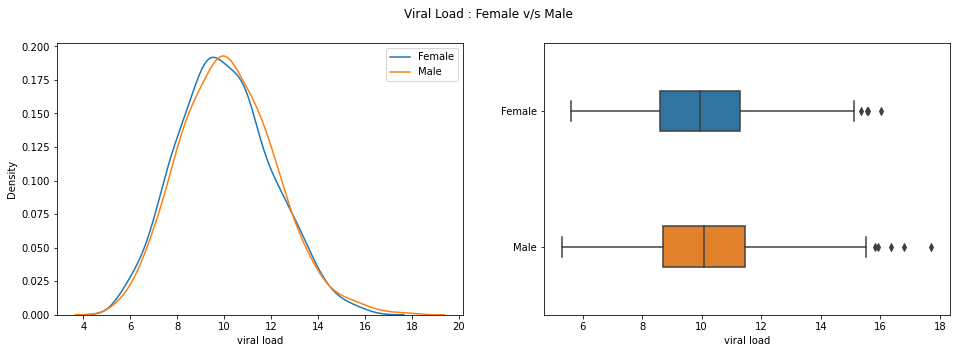

In [41]:
fvr = df[df["sex"]=="female"]
mvr = df[df["sex"]=="male"]

fig, ax = plt.subplots(1,2,figsize=(16,5))

sns.distplot(fvr["viral load"], hist=False, ax=ax[0], label="Female")
sns.distplot(mvr["viral load"], hist=False, ax=ax[0], label="Male")
ax[0].legend()

sns.boxplot(x=df["viral load"], y=df["sex"], orient="h", width=0.3, ax=ax[1])
ax[1].set_yticklabels(["Female","Male"])
ax[1].set_ylabel(" ")

plt.suptitle("Viral Load : Female v/s Male")
plt.show()

As we see from the above visualizations, both the groups appear to follow normal distribution. We verify the same using the Shapiro test.

#### Shapiro-Wilk Normality test

In [42]:
stats.shapiro(fvr["viral load"])

ShapiroResult(statistic=0.9929257035255432, pvalue=0.004213363863527775)

In [43]:
stats.shapiro(mvr["viral load"])

ShapiroResult(statistic=0.9922773241996765, pvalue=0.0022284218575805426)

#### Q-Q Plot

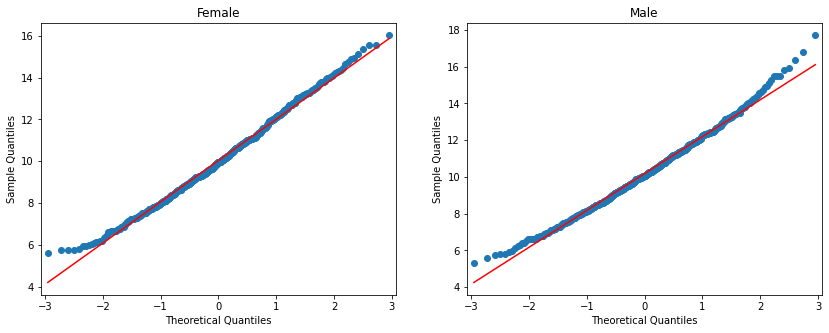

In [44]:
fig,ax = plt.subplots(1,2,figsize=(14,5))

sms.qqplot(fvr["viral load"], line='s', ax=ax[0])
sms.qqplot(mvr["viral load"], line='s', ax=ax[1])

ax[0].set_title("Female")
ax[1].set_title("Male")
plt.show()

Considering alpha = 0.05, we see that despite curves seeming normal from visualization, shapiro test gives a p-value of 0.004 and 0.002 and hence we reject the shapiro null that the data is drawn from normal distribution. 

However from the previous visualization of the distributions and the Q-Q Plot, they look approximately normal and thus can be assumed as such for practical purposes.

#### 
We will next check for equality of variances.

#### Levene's test for equality of variance

In [45]:
stats.levene(fvr["viral load"], mvr["viral load"], center='mean') #we use center as mean since the data is not much skewed

LeveneResult(statistic=0.002454463736173167, pvalue=0.9604947292785052)

We performed Levene's test for the transformed data.

The p-value is much greater than 0.05. So, we fail to reject the Null Hypothesis. This means the variance in viral load between female and male patients is not significantly different.

#### 

### T - Test (2 Sample, Right Tailed)

<b>H0 (Null Hypothesis)</b> : Mean viral load of female is equal to male ($\mu_{female} == \mu_{male}$)

<b>HA (Alternate Hypothesis)</b> : Mean viral load of female is greater than non smoker. ($\mu_{female} != \mu_{male}$)

<b>Significance Level :</b> 0.05

In [46]:
stats.ttest_ind(fvr["viral load"],mvr["viral load"], alternative="two-sided", equal_var=True)

Ttest_indResult(statistic=-1.3678519071811734, pvalue=0.1716006067515364)

So we performed T-test and found the p-value to be greater than 0.05. So we reject the null hypothesis. 


<b>Conclusion : </b> Thus it appears from the tests above that the mean viral load of male and female patients is not significantly different.
***
#### 
#### 

### B.3. Is the proportion of smoking significantly different across different regions?

In [47]:
pd.crosstab(df["smoker"],df["region"])

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,267,273,267
yes,55,46,60,46


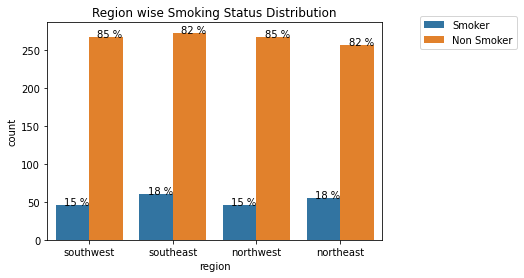

In [48]:
ax = sns.countplot("region", hue="smoker", data = df)

regs = ['southwest', 'southeast', 'northwest', 'northeast']
totals = [df[df["region"]==reg].count()[0] for reg in regs]*2

i=0
for p in ax.patches:
    txt = str(round(p.get_height()*100/totals[i]))+" %"
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x+0.1,txt_y,txt)
    i+=1

ax.legend(bbox_to_anchor=(1.1, 1.05), labels=["Smoker","Non Smoker"])
plt.title("Region wise Smoking Status Distribution")
plt.show()

From the visualization, we see that the proportion in fact, is not equal across various regions.

<b>H0 (Null Hypothesis)</b> : The proportion of smoking is not significantly different across different regions.

<b>HA (Alternate Hypothesis)</b> : The proportion of smoking is significantly different across different regions.

<b>Significance Level :</b> 0.05

In [49]:
from scipy.stats import chi2_contingency

In [50]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df["smoker"],df["region"]))
expected

array([[261.18646735, 262.02360346, 278.76632573, 262.02360346],
       [ 50.81353265,  50.97639654,  54.23367427,  50.97639654]])

In [51]:
p

0.511558235710166

So the p-value is greater than 0.05, and we fail to reject the Null that smoking does not depend on region.

<b>Conclusion :</b> Thus we see that the proportion of smoking in fact does not depends on region (it does not vary significantly across regions)
***

#### 
#### 

### B.4. Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same?

In [52]:
df[df["sex"]=="female"].groupby(['severity level'])['viral load'].describe()[0:3]

,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,278.0,10.022086,1.937819,5.76,8.6425,9.92,11.165,14.92
1,151.0,9.937682,1.928605,5.60,8.6150,9.75,11.130,15.36
2,113.0,10.079912,2.133338,5.73,8.4300,10.23,11.430,16.02


Since the severity levels have different counts each, we pick random samples of size 113 each.

In [53]:
sv0 = df[(df['severity level']==0) & (df['sex']=='female')]['viral load'].sample(113)
sv1 = df[(df['severity level']==1) & (df['sex']=='female')]['viral load'].sample(113)
sv2 = df[(df['severity level']==2) & (df['sex']=='female')]['viral load'].sample(113)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


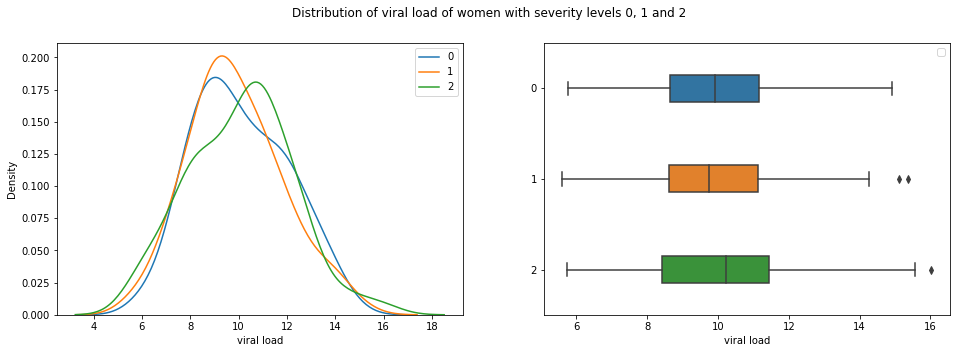

In [54]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

sns.distplot(sv0, hist=False, label="0", ax=ax[0])
sns.distplot(sv1, hist=False, label="1", ax=ax[0])
sns.distplot(sv2, hist=False, label="2", ax=ax[0])
ax[0].legend()

sns.boxplot(x=df[(df["sex"]=="female") & (df["severity level"].isin([0,1,2]))]["viral load"], y=df[df["severity level"].isin([0,1,2])]["severity level"], orient="h", width=0.3, ax=ax[1])
ax[1].set_ylabel(" ")

plt.legend()
plt.suptitle("Distribution of viral load of women with severity levels 0, 1 and 2")
plt.show()

From the plot above, we can consider the distributions to be approximately normal for practical purposes.

Next we check for equality of variance.

#### Levene's test for equality of variance

In [55]:
stats.levene(sv0,sv1,sv2)

LeveneResult(statistic=0.5520038255668658, pvalue=0.5763161268731914)

The p-value is much greater than 0.05. So, we fail to reject the Null Hypothesis. This means the variance in viral load of females between different severity levels (0,1,2) is not significantly different.

#### 

<b>H0 (Null Hypothesis)</b> : The mean viral load of women with severity levels 0,1 and 2 are same. ($\mu_0 = \mu_1 = \mu_2$)

<b>HA (Alternate Hypothesis)</b> : At least one of the means is different from the others.

<b>Significance Level :</b> 0.05

### One Way ANOVA

In [56]:
stats.f_oneway(sv0,sv1,sv2)

F_onewayResult(statistic=0.4306838752123227, pvalue=0.650422734000996)

So the p-value is much greater than 0.05, and we fail to reject the Null that mean of women with severity level 0,1 and 2 is equal.

<b>Conclusion :</b> Thus we see that the mean viral load of women with different severity levels are not significantly different.

***

## C. Insights and Recommendations


### C.1. Insights:

1. We see that the age group 18-20 has a lot of patients (above 130). The rest of the groups have below 60 patients each.
2. The gender distribution is 50-50 (both genders equally represented) in the data.
3. Only 16% of the patients are smokers where as 84% are non smokers.
4. All the 4 regions have almost similar distribution (25% each).

5. The viral load ditribution looks approximately normal. 
- The mean viral load is around 10. 
- 68% of observations have viral load between 8 and 12.
- 95% of observations have viral load between 6 and 14.
- 99% of observations have viral load between 4 and 16.

6. Severity level 0 has highest observations (almost 43%), followed by 1 (24%), 2 (17%) and 3 (12%). Very few have severiy 4 and above (less than 2%).

7. Hospitalization charges have a distribution with two peaks. We see many observations with hospitalization charges between INR 0 to INR 40000. The number of observations with charges from INR 40000 to INR 80000 reduces. It rises again between INR 80000 and INR 111000. This might be because of higher hospitalization charges incurred by smokers. So the second rise is probably due to smoker patients, while the first peak is non smokers.
-  Hospitalization Charges incurred increases with increase in age. 
 - Hospitalization charges increase with age for each gender.
 - In age groups 10-20, 20-30, 30-40, 40-50, males tend to incur more charges than female. However in the 50-60 and 60+ age group, females incur more charges than males.
 - The above point might be because there are more female patients in the 50-60 and 60+ age group. However for the 40-50 age group, despite there being more female patients, male patients still incur more charges overall.
 - Male and female patients have similar hospitalization charges.
 - Smokers have a much greater hospitalization charge than non-smokers.
- The different regions seem to have similar trends in median hospitalization charge.
-  Severity level 0 strangely, has a little higher median hospitalization charge than 1 and 2. There is a slight increasing trend from levels 1 to 4.
-  Severity level 5 again has lower charge (but has only about 1% observations).
- There does not seem to be a clear correlation between viral load and hospitalization charges.
- There does not seem to be a clear correlation between viral load and age.

8. Viral Load : 
- There does not seem to be much difference between the viral load of male and female patients.
 - There again does not seem to be a clear relation between severity levels and viral load.
 - Viral load of smokers seems to be lower than non-smokers. (Since lower CT values indicate higher load, it appears that the viral load reported is actually the CT value. So smokers have lower CT values and hence higher load).
 - Patients from SouthEast seem to have highest CT value (lowest viral load).

9. Southeast and Northeast have higher smoker percentage (18%) than Southwest and Northwest (15%).

10. Viral load in women :
- The viral load distributions for severity levels 0 and 1 seem to follow similar distributions.  Severity level 2 is slightly differently distributed.
- However the mean viral load is almost same across all the groups.



### C.2. Hypothesis Test Conclusions and Recommendations

1. The mean hospitalization charge of smokers is significantly greater than that of non-smokers.
2. The mean viral load of male and female patients is not significantly different.
3. The proportion of smoking is significantly different across different regions.
3.  The mean viral load of women with different severity levels (0,1,2) are not significantly different.

A. We see that smokers incur higher charges. Companies can urge their employees who are smokers, to opt for additional insurance coverage.
B. This can also be treated as a lesson in dangers of smoking and companies can use the findings to raise awareness among employees, introduce rehabilitation programs and plans to incentivize stopping smoking.
C. The regions where there are greater proportion of smokers (SouthEast and NorthEast) can be the target candidates for a pilot run of such programs, and these can gradually be introduced elsewhere.
D. Employees in the older age brackets might be advised to exercise more caution.
E. Employees who have recently quit smoking or are in the process of quitting can be provided with additional targeted check up sessions to assess their risk and health status. 